<a href="https://colab.research.google.com/github/americanthinker/vectorsearch-applications/blob/main/notebooks/4-Reranking_Week2.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Week 2: Building Advanced RAG Applications.  Authored by Chris Sanchez.

# Week 2 - Notebook 4

# Overview

Welcome to Week 2 of the course!  We covered a lot of content last week in order to get to the point where we can search over our data.  In this notebook, you'll have the chance to improve your baseline retrieval scores by combining the strengths of keyword and vector search using Weaviate's `hybrid_search` method.  We'll also incorporate the use of a CrossEncoder reranker to pack the final punch in our retrieved hits, before we pass those results to the LLM for answer synthesis.  Here's a reminder of where we've been and where we're going:

#### Week One
* ~Part 1:~
  * ~Data ingest and preprocessing~
  * ~Convert text into vectors~
* ~Part 2~:
  * ~Index data on Weaviate database~
  * ~Search over data~
* ~Part 2.5~:
  * ~Benchmark retrieval results~

#### Week Two
* **Part 4 (THIS NOTEBOOK)**:
  * **Add Hybrid Search and ReRanker to the mix (new benchmark)**
* Part 5:
  * LLM Integration

#### This notebook will cover the highlighted portion of the technical diagram below, as initially referenced in the Course content:

![arch diagram]( 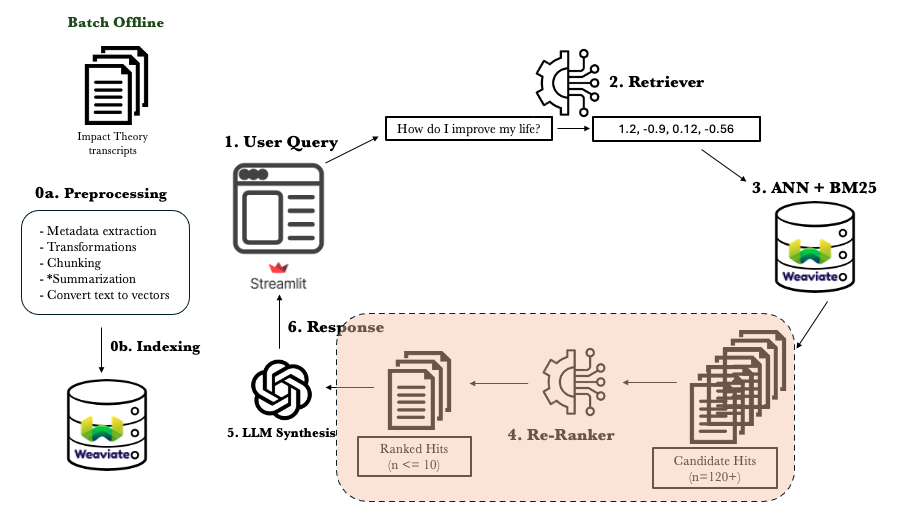)

In [2]:
import sys
sys.path.append('../')

#load from local .env file
from dotenv import load_dotenv, find_dotenv
env = load_dotenv('.env', override=True)

#standard python
from typing import List, Dict, Tuple
import os

# external libraries
from tqdm import tqdm
from rich import print  # nice library that provides improved printing output (overrides default print function)

# external files
from src.reranker import ReRanker
from src.database.weaviate_interface_v4 import WeaviateWCS

## Setup 
***

### Instaniate Weaviate Client

In [12]:
#read env vars from local .env file
api_key = os.environ['WEAVIATE_API_KEY']
url = os.environ['WEAVIATE_ENDPOINT']

model_name = "sentence-transformers/all-MiniLM-L6-v2"

#instantiate client
client = WeaviateWCS(endpoint=url, api_key=api_key, model_name_or_path=model_name)

In [14]:
#display available collection names on cluster
client.show_all_collections()

['Huberman_all_minilm_l6_v2_128',
 'Huberman_all_minilm_l6_v2_256',
 'Huberman_all_minilm_l6_v2_512',
 'Huberman_bge_base_en_v15_128',
 'Huberman_bge_base_en_v15_256',
 'Huberman_bge_base_en_v15_512',
 'Huberman_bge_base_en_v15_ft_quora_09_256']

### Set Collection name

In [13]:
#set collection name to run queries on
collection_name = "Huberman_all_minilm_l6_v2_256"

## Discussion  

Hybrid search does just what it sounds like: it combines a keyword search with a vector search, which has the effect of combining the strengths of each method for improved retrieval.  If you'll recall, the initial vector retrieval results we saw with our out-of-the-box `miniLM` model were about 20 percentage points lower compared to the keyword results. My initial results with the `chunk_size` 256 dataset were `kw_hit_rate` of `.90` and a `vector_hit_rate` of a relatively lackluster `.71`: 

```
{'n': 5,
 'Retriever': 'sentence-transformers/all-MiniLM-L6-v2',
 'chunk_size': 256,
 'query_props': ['content'],
 'kw_hit_rate': 0.9,
 'kw_mrr': 0.82,
 'vector_hit_rate': 0.71,
 'vector_mrr': 0.59,
 'total_misses': 8,
 'total_questions': 100}
```
You may also have noticed that the `total_misses` score was `8`, meaning that neither method picked up the golden `doc_id` in the "n" retrieved results, a total of 8 times.  From another perspective, it means that between keyword and vector search, they found 92 out of 100 of the golden `doc_ids`.  So if 92 docs were found then how come we don't see a hit rate score of 92 in one of the two methods....?

If you compare the total misses with the keyword hit rate (the highest scoring method), you'll see that keyword picked up 90 of the correct docs, but the combined results picked up 92.  We can interpret this to mean that the vector search method accounts for the difference of 2 hits between the keyword hit rate and the total of 92 correct documents found.  Combining these two search methods through hybrid search allows us to close this gap. 

# Hybrid Search - `RelativeRankFusion`  
If you recall from the [Course Notes](https://uplimit.com/course/rag-applications/v2/module/module_clt3drq56007916lf8af5ey4c#corise_clpwr52t6001q2e6fnm5mn5ar), Weaviate's Hybrid search method uses the `RelativeRankFusion` algorithm under the hood. Combining keyword and vector search scores is an area of active research, so the algorithm used by Weaviate is "a" way to perform hybrid search, not "the" way.  

**Let's walk through the steps at a high level and then break it down in code:**
1. Execute a keyword and a vector search and get the raw scores and doc_ids of each.
2. Normalize scores between 0 and 1 relative to each method.
3. Multiply the normalized scores by a weighted value: `alpha`.
4. Add scores together that both have the same `doc_id`.
5. Combine search results together in ranked order according to score values. 

### Get responses to query

In [9]:
query = 'How will listening to Huberman Lab improve my life'

In [15]:
kw_response = client.keyword_search(query, collection_name, limit=10)
vector_response = client.vector_search(query, collection_name, limit=10)

### Extract scores and doc_ids

In [16]:
from collections import OrderedDict

def get_scores_ids(response: list[dict], include_cross_score: bool=False, limit: int=10):
    '''
    Extracts scores and ids from response object.
    If keyword, extracts from "score" field.
    If vector, extracts from "distance" field and
    subtracts from 1 in keeping with the concept that
    higher scores are better.
    '''
    def round_(score: str, place: int=3):
        return round(float(score),place)

    if response[0].get('score'):
        if include_cross_score:
            return {d['doc_id'] : f'Score: {round_(d["score"])}   :   Cross-Score: {round_(d["cross_score"])}' for d in response[:limit]}
        return {d['doc_id'] : round_(d['score'], 3) for d in response[:limit]}
    return {d['doc_id'] : round_(1 - d['distance'],3) for d in response[:limit]}

### Raw scores
Using the above function we're going to pull out the `doc_ids` and the raw (unnormalized) scores from each search method. Note the difference in score magnitude between BM25 ranking and the Cosine score.

In [17]:
kw_scores = get_scores_ids(kw_response)
vec_scores = get_scores_ids(vector_response)
kw_scores, vec_scores

({'yb5zpo5WDG4_0': 7.535,
  'Ze2pc6NwsHQ_0': 7.381,
  'qPKd99Pa2iU_0': 7.309,
  'x3MgDtZovks_0': 7.146,
  'CQlTmOFM4Qs_89': 6.993,
  'JVRyzYB9JSY_0': 6.918,
  'szqPAPKE5tQ_0': 6.89,
  'sxgCC4H1dl8_0': 6.852,
  'hFL6qRIJZ_Y_0': 6.839,
  'CQlTmOFM4Qs_0': 6.83},
 {'0RYyQRQFgFk_112': 0.697,
  'gE0_8AjTFaM_2': 0.67,
  'RI112zW8GDw_129': 0.667,
  'GVRDGQhoEYQ_134': 0.66,
  'TG8VM5-CTfw_172': 0.656,
  'Z7MU6zrAXsM_126': 0.648,
  'p4ZfkezDTXQ_188': 0.641,
  'HYVeP4F0GNU_141': 0.637,
  'FeRgqJVALMQ_132': 0.634,
  'Rxmv7rT9leo_99': 0.633})

### Normalize scores relative to each method
Normalize all scores so that the values are between 0 and 1 relative to one other **within** each method.  In other words we are normalizing scores for each method, not normalizing across all scores, because this will not work in practice given that a BM25 score has no meaning relative to a Cosine Similarity score.  

In [18]:
#using sklearn to normalize scores
from sklearn.preprocessing import MinMaxScaler
from numpy import ndarray

scaler = MinMaxScaler()
kw_normal = scaler.fit_transform([[score] for score in kw_scores.values()])
vec_normal = scaler.fit_transform([[score] for score in vec_scores.values()])
kw_normal, vec_normal

(array([[1.        ],
        [0.78156028],
        [0.67943262],
        [0.44822695],
        [0.23120567],
        [0.1248227 ],
        [0.08510638],
        [0.03120567],
        [0.01276596],
        [0.        ]]),
 array([[1.      ],
        [0.578125],
        [0.53125 ],
        [0.421875],
        [0.359375],
        [0.234375],
        [0.125   ],
        [0.0625  ],
        [0.015625],
        [0.      ]]))

### Multiply by weighted alpha value

Weight the values by multiplying by the `alpha` parameter. `alpha` is an indication of how strong we want to weight the scores toward vector search.  Setting `alpha` to 0 results in a pure keyword search (vector scores will be multiplied by 0, meaning they won't be considered as part of the search results) and setting `alpha` to 1 results in a pure vector-based search. For this example we'll set `alpha` to `0.45` meaning we'll multiply the vector scores by `0.45` (thus diminishing their importance to the returned results) and multiply the keyword scores by `0.55` (boosting their importance to the returned results).  

In [19]:
alpha = 0.45
kw_weighted = kw_normal * (1 - alpha)
vec_weighted = vec_normal * alpha
kw_weighted, vec_weighted

(array([[0.55      ],
        [0.42985816],
        [0.37368794],
        [0.24652482],
        [0.12716312],
        [0.06865248],
        [0.04680851],
        [0.01716312],
        [0.00702128],
        [0.        ]]),
 array([[0.45      ],
        [0.26015625],
        [0.2390625 ],
        [0.18984375],
        [0.16171875],
        [0.10546875],
        [0.05625   ],
        [0.028125  ],
        [0.00703125],
        [0.        ]]))

### Update final scores

After intra-method normalization and score weighting, we can now update our docs with their new scores.  One more step to complete is to add together any scores coming from the same document in both results.  This should make intuitive sense, we want to boost the scores of documents that **both** methods picked up.  

In [20]:
def update_scores(weighted_kw_scores: ndarray,
                  weighted_vec_scores: ndarray
                 ) -> None:
    for i, k in enumerate(kw_scores):
        kw_scores[k] = weighted_kw_scores[i][0]
    for i, k in enumerate(vec_scores):
        vec_scores[k] = weighted_vec_scores[i][0]

In [21]:
update_scores(kw_weighted, vec_weighted)

#the updated scores should look very different from their original raw scores
kw_scores, vec_scores

({'yb5zpo5WDG4_0': 0.55,
  'Ze2pc6NwsHQ_0': 0.4298581560283688,
  'qPKd99Pa2iU_0': 0.3736879432624117,
  'x3MgDtZovks_0': 0.24652482269503512,
  'CQlTmOFM4Qs_89': 0.12716312056737566,
  'JVRyzYB9JSY_0': 0.06865248226950316,
  'szqPAPKE5tQ_0': 0.04680851063829721,
  'sxgCC4H1dl8_0': 0.017163120567376036,
  'hFL6qRIJZ_Y_0': 0.007021276595744386,
  'CQlTmOFM4Qs_0': 0.0},
 {'0RYyQRQFgFk_112': 0.45,
  'gE0_8AjTFaM_2': 0.2601562500000008,
  'RI112zW8GDw_129': 0.23906250000000082,
  'GVRDGQhoEYQ_134': 0.1898437500000008,
  'TG8VM5-CTfw_172': 0.1617187500000008,
  'Z7MU6zrAXsM_126': 0.1054687500000008,
  'p4ZfkezDTXQ_188': 0.0562500000000008,
  'HYVeP4F0GNU_141': 0.0281250000000008,
  'FeRgqJVALMQ_132': 0.0070312500000008,
  'Rxmv7rT9leo_99': 0.0})

### Add together any documents with the same doc_id and then sort final results

In [22]:
def add_doc_scores(kw_scores: Dict[str, float],
                   vec_scores: Dict[str, float],
                   top_k: int=5
                  ) -> List[Tuple[str, float]]:
    '''
    Combined keyword and vector scores by adding values
    for any duplicate docs and then sorts resulting
    dictionary of results.  Returns top_k values.
    '''
    hybrid_results = kw_scores
    for k,value in vec_scores.items():
        if k in kw_scores:
            hybrid_results[k] += value
        else:
            hybrid_results[k] = value
    return sorted(hybrid_results.items(), key=lambda x: x[1], reverse=True)[:top_k]

In [23]:
# #compare these final ranked value with the original keyword and vector queries
ranked_results = add_doc_scores(kw_scores, vec_scores, top_k=5)
ranked_results

[('yb5zpo5WDG4_0', 0.55),
 ('0RYyQRQFgFk_112', 0.45),
 ('Ze2pc6NwsHQ_0', 0.4298581560283688),
 ('qPKd99Pa2iU_0', 0.3736879432624117),
 ('gE0_8AjTFaM_2', 0.2601562500000008)]

### Compare manually generated scores with Weaviate hybrid method

In [24]:
#scores and ranking are slightly off due to the way that keyword results are processed

hyb_response = client.hybrid_search(query, collection_name, alpha=alpha, limit=5)
get_scores_ids(hyb_response), ranked_results

({'0RYyQRQFgFk_112': 0.581,
  'yb5zpo5WDG4_0': 0.55,
  'Ze2pc6NwsHQ_0': 0.515,
  'qPKd99Pa2iU_0': 0.498,
  'CQlTmOFM4Qs_89': 0.491},
 [('yb5zpo5WDG4_0', 0.55),
  ('0RYyQRQFgFk_112', 0.45),
  ('Ze2pc6NwsHQ_0', 0.4298581560283688),
  ('qPKd99Pa2iU_0', 0.3736879432624117),
  ('gE0_8AjTFaM_2', 0.2601562500000008)])

# Assignment 2.1 - Compare Search Methods
***
**Submit queries using the various search methods and observe how the results, and their ordering, changes.**

#### Instructions:
- Run the print statements and observe how the results change (or don't) based on the search method. 
- Play around with the `alpha_value` parameter and notice how the hybrid search results match the other search methods depending on how close to zero or one the value is.
- Once you have a comfortable understanding of how hybrid search compares to the other methods, move on to Reranking. 

In [25]:
def print_results_by_key(results: list[dict], return_props: list[str]) -> None:
    '''
    Pretty-prints nested search results
    '''
    from rich.pretty import pprint
    keys = return_props + ['score', 'distance']
    for r in results:
        for key in r:
            if key in keys:
                pprint(f'{key.upper()}: {r[key]}')
        print('\n\n')
    print('-'*100)

In [26]:
def print_results(client: WeaviateWCS,
                  collection_name: str,
                  queries: list[str],
                  return_props: list[str],
                  alpha_value: float
                  ) -> None:
    '''
    Prints search results grouped by search method
    '''
    for q in queries:
        kw_result = client.keyword_search(q, collection_name, return_properties=return_props, limit=3)
        vector_result = client.vector_search(q, collection_name, return_properties=return_props, limit=3)
        hybrid_result = client.hybrid_search(q, collection_name, return_properties=return_props, alpha=alpha_value, limit=3)
        print('*'*100)
        print(f'QUERY: {q}')
        print('*'*100)
        print(f'KEYWORD RESULTS:')
        print_results_by_key(kw_result, return_props)
        print(f'VECTOR RESULTS:')
        print_results_by_key(vector_result, return_props)
        print(f'HYBRID RESULTS:')
        print_results_by_key(hybrid_result, return_props)

In [27]:
queries = ['How to fight age-related muscle loss', 'How can listeners support the Huberman Lab podcast', 'What is the role of the mid-singulate cortex in the human brain']
return_props = ['title', 'content', 'doc_id']
alpha_value = 0.4

print_results(client, collection_name, queries, return_props, alpha_value)

****************************************************************************************************

QUERY: How to fight age-related muscle loss

****************************************************************************************************

KEYWORD RESULTS:

"CONTENT: In general, human movement is a function of, number one, some sort of neuromuscular activation. So nerves have to turn on. The second part is muscles have to contract. And the third part is those muscles have to move a bone. All right. If you want to be alive and you want to live by yourself, you have to be able to engage in human movement. If you have any dysfunction in the neuromuscular system there, then you're not going to be able to do that. And again, as I mentioned, the only way to preserve that or fight that loss of aging is to strength train. So people will tend to hear numbers like you lose about 1% of muscle size per year after age about 40. And that's true. However, what they don't realize is you lose about 2% to 4% of your strength per year. So the loss of strength is almost double that, the loss of muscle mass with aging. Muscle power is more like 8% to 10% per year."

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

'DOC_ID: CyDLbrZK75U_4'

'SCORE: 8.985105514526367'

"CONTENT: I also would like to make one brief correction to something that I said incorrectly in the previous episode. At the end of the episode, I talked about lutein and how lutein may help offset some moderate to severe age-related macular degeneration. As well, I talked about how some people are supplementing with lutein even though they don't have age-related macular degeneration with the idea in mind that it might help offset some vision loss as they get older. I said lutein, and lutein was the correct thing to say, but once or twice when I started speaking fast, I said leucine and not lutein. I want to emphasize that leucine and amino acid, very interesting, important for muscle building, covered in previous episodes, but lutein, L-U-T-E-I-N, is the molecule and compound that I was referring to in terms of supplementing for sake of vision. So I apologize, please forgive me, I misspoke. A couple of you caught that right away in listening to the episode after it went up, I realized that I'd misspoken."

'TITLE: How Smell, Taste & Pheromone-Like Chemicals Control You'

'DOC_ID: Mwz8JprPeMc_11'

'SCORE: 7.743038654327393'

"CONTENT: Basically the takeaway from this study was that mice and humans can utilize amino acids that are ingested early in the day better than they can utilize amino acids ingested later in the day, in particular toward muscle hypertrophy and growth or maintenance of muscle, which for those of you that aren't interested in muscle hypertrophy, that aren't trying to grow your muscles, I've talked before in the episode on building strength and hypertrophy, that maintaining muscle, regardless of one's athletic prowess, regardless of one's age, is extremely important because loss of skeletal muscle is one of the major causes of injury as we age. It's one of the major causes, believe it or not, of cognitive and metabolic deficits as we age. So maintaining muscle is important. Building muscle might be important to some of you, but what they found was ingesting protein early in the day and these amino acids early in the day led to more muscle hypertrophy than if the majority of amino acids and proteins were ingested late in the day. So this translates to intermittent fasting such that if you are interested in muscle hypertrophy, you might, and I want to emphasize might, consider making sure that you're getting sufficient protein intake early in the day."

'TITLE: Healthy Eating & Eating Disorders - Anorexia, Bulimia, Binging | Huberman Lab Podcast #36'

'DOC_ID: 2XGREPnlI8U_11'

'SCORE: 6.993916988372803'

----------------------------------------------------------------------------------------------------

VECTOR RESULTS:

"CONTENT: In general, human movement is a function of, number one, some sort of neuromuscular activation. So nerves have to turn on. The second part is muscles have to contract. And the third part is those muscles have to move a bone. All right. If you want to be alive and you want to live by yourself, you have to be able to engage in human movement. If you have any dysfunction in the neuromuscular system there, then you're not going to be able to do that. And again, as I mentioned, the only way to preserve that or fight that loss of aging is to strength train. So people will tend to hear numbers like you lose about 1% of muscle size per year after age about 40. And that's true. However, what they don't realize is you lose about 2% to 4% of your strength per year. So the loss of strength is almost double that, the loss of muscle mass with aging. Muscle power is more like 8% to 10% per year."

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

'DOC_ID: CyDLbrZK75U_4'

'DISTANCE: 0.3511980175971985'

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

"CONTENT: In fact, there's actually interesting data that just came out showing this reduction in muscle strength and hypertrophy that I sort of talked about is basically ameliorated with a preservation of activity. In other words, you don't lose these functionalities because of aging. You lose these because of a loss of training. To state that again, you don't lose these because of some innate physiological thing that happens with genes become less sensitive or you lose functionality. You pretty much can describe the loss of function of strength and muscle in aging as exclusively because of a loss of training and nutrition and anabolic resistance and some other things. So you can do a lot more than you think when it comes to maintaining high quality muscle. And that's really important to point out. I'm reminded of the words of the great Sherrington. He won the Nobel prize as a physiologist. I guess the neuroscientists try and claim him as a neuroscientist because he worked on the nervous system. The physiologists claim as a, as a physiologist. He is 100% a physiologist. I would call him a neuroscientist. Maybe we can argue about this later."

'DOC_ID: CyDLbrZK75U_8'

'DISTANCE: 0.35205674171447754'

"CONTENT: That's also because we know that maintaining or improving strength of our muscles is very important across the entire lifespan, but especially in the years spanning from 40 until death, which I think for most people fall somewhere between 50, 60, 70, or ideally out into the 80s, 90s, or hundreds, right? That's what we're all seeking is to die later in better health. And in order to do that, we have to dedicate some very specific training protocols in order to maintain or build strength. So to summarize, in addition to all the positive reasons to do dedicated strength training that I mentioned before, it's highly recommended that you do some dedicated strength training for the purposes of offsetting the age-related decline in strength that occurs. Again, three to 5% per year past age 40, which is a pretty significant decline. But the good news is if you do the three to five protocol for say 12 weeks per year, and then you continue to resistance train using other repetition ranges geared towards hypertrophy and strength, or perhaps even muscular endurance. The good news is you'll maintain your strength and perhaps even build your strength, offsetting that natural decrease that would otherwise occur."

'TITLE: Science-Supported Tools to Accelerate Your Fitness Goals | Huberman Lab Podcast'

'DOC_ID: LYYyQcAJZfk_34'

'DISTANCE: 0.3765738010406494'

----------------------------------------------------------------------------------------------------

HYBRID RESULTS:

"CONTENT: In general, human movement is a function of, number one, some sort of neuromuscular activation. So nerves have to turn on. The second part is muscles have to contract. And the third part is those muscles have to move a bone. All right. If you want to be alive and you want to live by yourself, you have to be able to engage in human movement. If you have any dysfunction in the neuromuscular system there, then you're not going to be able to do that. And again, as I mentioned, the only way to preserve that or fight that loss of aging is to strength train. So people will tend to hear numbers like you lose about 1% of muscle size per year after age about 40. And that's true. However, what they don't realize is you lose about 2% to 4% of your strength per year. So the loss of strength is almost double that, the loss of muscle mass with aging. Muscle power is more like 8% to 10% per year."

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

'DOC_ID: CyDLbrZK75U_4'

'SCORE: 1.0'

"CONTENT: Basically the takeaway from this study was that mice and humans can utilize amino acids that are ingested early in the day better than they can utilize amino acids ingested later in the day, in particular toward muscle hypertrophy and growth or maintenance of muscle, which for those of you that aren't interested in muscle hypertrophy, that aren't trying to grow your muscles, I've talked before in the episode on building strength and hypertrophy, that maintaining muscle, regardless of one's athletic prowess, regardless of one's age, is extremely important because loss of skeletal muscle is one of the major causes of injury as we age. It's one of the major causes, believe it or not, of cognitive and metabolic deficits as we age. So maintaining muscle is important. Building muscle might be important to some of you, but what they found was ingesting protein early in the day and these amino acids early in the day led to more muscle hypertrophy than if the majority of amino acids and proteins were ingested late in the day. So this translates to intermittent fasting such that if you are interested in muscle hypertrophy, you might, and I want to emphasize might, consider making sure that you're getting sufficient protein intake early in the day."

'TITLE: Healthy Eating & Eating Disorders - Anorexia, Bulimia, Binging | Huberman Lab Podcast #36'

'DOC_ID: 2XGREPnlI8U_11'

'SCORE: 0.6424848437309265'

"CONTENT: In fact, there's actually interesting data that just came out showing this reduction in muscle strength and hypertrophy that I sort of talked about is basically ameliorated with a preservation of activity. In other words, you don't lose these functionalities because of aging. You lose these because of a loss of training. To state that again, you don't lose these because of some innate physiological thing that happens with genes become less sensitive or you lose functionality. You pretty much can describe the loss of function of strength and muscle in aging as exclusively because of a loss of training and nutrition and anabolic resistance and some other things. So you can do a lot more than you think when it comes to maintaining high quality muscle. And that's really important to point out. I'm reminded of the words of the great Sherrington. He won the Nobel prize as a physiologist. I guess the neuroscientists try and claim him as a neuroscientist because he worked on the nervous system. The physiologists claim as a, as a physiologist. He is 100% a physiologist. I would call him a neuroscientist. Maybe we can argue about this later."

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

'DOC_ID: CyDLbrZK75U_8'

'SCORE: 0.5133733749389648'

----------------------------------------------------------------------------------------------------

****************************************************************************************************

QUERY: How can listeners support the Huberman Lab podcast

****************************************************************************************************

KEYWORD RESULTS:

"CONTENT: And be sure to check out the Waking Up app that Dr. Sam Harris has made free to any Huberman Lab listeners for 30 days by going to wakingup.com slash Huberman. Please also check out his incredible podcast, the Making Sense podcast. And you can find any number of Sam Harris's different books on meditation, consciousness, philosophy, neuroscience, politics, and more. You can find links to those books by going to samharris.org. If you're learning from and or enjoying this podcast, please subscribe to our YouTube channel. That's the best zero cost way to support us. In addition, please subscribe to the podcast on Spotify and Apple. And on both Spotify and Apple, you can leave us up to a five-star review. If you have questions for us or comments or topics that you'd like me to cover, or guests you'd like me to invite onto the Huberman Lab podcast, please put those in the comment section on YouTube. I do read all the comments. Please also check out the sponsors mentioned at the beginning and throughout today's episode. That's the best way to support this podcast."

'TITLE: Dr. Sam Harris: Using Meditation to Focus, View Consciousness & Expand Your Mind | Huberman Lab 105'

'DOC_ID: -wIt_WsJGfw_228'

'SCORE: 10.142988204956055'

"CONTENT: Nonetheless, I think many people who are listeners of this podcast are interested in the things that they can do in order to inoculate themselves or at least reduce the likelihood of experiencing headache, especially for people who are experiencing chronic recurring headaches, such as migraine or the other forms of headache, which can be so debilitating. Thank you for joining me for today's discussion. If you're learning from and or enjoying this podcast, please subscribe to our YouTube channel. That's the best zero cost way to support us. In addition, please subscribe to the podcast on Spotify and Apple. And on both Spotify and Apple, you can leave us up to a five-star review. If you have questions for me or comments about the podcast or guests that you'd like me to include on the Huberman Lab podcast, please put all of that in the comment section on YouTube. I do read all the comments. In addition, please check out the sponsors mentioned at the beginning and throughout today's episode. That's the best way to support this podcast. If you're not already following us on social media, we are Huberman Lab on Instagram, Twitter, Facebook, and LinkedIn."

'TITLE: How to Stop Headaches Using Science-Based Approaches | Huberman Lab Podcast'

'DOC_ID: CGjdgy0cwGk_144'

'SCORE: 9.80562686920166'

"CONTENT: Thank you for joining me for today's discussion all about science-based protocols for how to set and pursue your goals. If you're learning from and or enjoying this podcast, please subscribe to our YouTube channel. That's a terrific zero cost way to support us. In addition, please subscribe to the podcast on both Spotify and Apple. And on both Spotify and Apple, you can leave us up to a five-star review. If you have questions for me or comments about the podcast or guests that you'd like me to consider hosting on the Huberman Lab podcast, please put those in the comment section on YouTube. I do read all the comments. Please also check out the sponsors mentioned at the beginning and throughout today's episode. That's the best way to support this podcast. Not on today's podcast, but on many previous episodes of the Huberman Lab podcast, we discuss supplements. While supplements aren't necessary for everybody, many people derive tremendous benefit from them for things like improving sleep, hormone support, and focus. The Huberman Lab podcast has partnered with Momentous Supplements. If you'd like to access the supplements discussed on the Huberman Lab Thank you so much for joining us."

'TITLE: Goals Toolkit: How to Set & Achieve Your Goals | Huberman Lab Podcast'

'DOC_ID: CrtR12PBKb0_92'

'SCORE: 9.175667762756348'

----------------------------------------------------------------------------------------------------

VECTOR RESULTS:

"CONTENT: Paul Conte. If you're learning from and or enjoying this podcast, please subscribe to our YouTube channel. That's a terrific zero cost way to support us. In addition, please subscribe to the podcast on both Spotify and Apple. And on both Spotify and Apple, you can leave us up to a five-star review. Please also check out the sponsors mentioned at the beginning and throughout today's episode. That's the best way to support this podcast. If you have questions for me or comments about the podcast or guests that you'd like me to consider hosting on the Huberman Lab podcast, please put those in the comments section on YouTube. I do read all the comments. And if you're not already following me on social media, I am Huberman Lab on all platforms. So that's Instagram, Twitter, LinkedIn, Threads and Facebook. And on all those platforms, I discuss science and science related tools, some of which overlap with the content of the Huberman Lab Podcast, but much of which is distinct from the content of the Huberman Lab Podcast. So again, it's Huberman Lab on all social media channels."

'TITLE: Dr. Paul Conti: How to Improve Your Mental Health | Huberman Lab Guest Series'

'DOC_ID: qPKd99Pa2iU_186'

'DISTANCE: 0.21911132335662842'

"CONTENT: There you will also see a tab for support where if you like, you can make a tax deductible donation to support the incredible research that Dr. Crum and her colleagues are doing. If you're learning from and or enjoying the Huberman Lab Podcast, please subscribe to our YouTube channel. That's a terrific zero cost way to support us. In addition, please subscribe to us on Apple and Spotify. And on Apple, you have the opportunity to leave us up to a five-star review. On YouTube, you also have the opportunity to leave us questions and comments in the comment section below any of the episodes. You can also make suggestions about future guests that you'd like us to host on the Huberman Lab Podcast. Please also check out our sponsors mentioned at the beginning of this episode. That's the best way to support this podcast. We also have a Patreon, it's patreon.com slash Andrew Huberman. And there you can support the podcast at any level that you like. If you're not already following us on Instagram and on Twitter, we are Huberman Lab at both Instagram and Twitter. And there I teach neuroscience in short form, sometimes videos, sometimes text slides."

'TITLE: Dr. Alia Crum: Science of Mindsets for Health & Performance | Huberman Lab Podcast #56'

'DOC_ID: dFR_wFN23ZY_86'

'DISTANCE: 0.23019516468048096'

"CONTENT: That's a terrific zero cost way to support us. In addition, please subscribe to the podcast on both Spotify and Apple. And on both Spotify and Apple, you can leave us up to a five-star review. Please also check out the sponsors mentioned at the beginning and throughout today's episode. That's the best way to support this podcast. If you have questions for me or comments about the podcast or guests that you'd like me to consider hosting on the Huberman Lab podcast, please put those in the comments section on YouTube. I do read all the comments. And if you're not already following me on social media, I am Huberman Lab on all platforms. So that's Instagram, Twitter, LinkedIn, Threads, and Facebook. And on all those platforms, I discuss science and science-related tools, some of which overlap with the content of the Huberman Lab podcast, but much of which is distinct from the content of the Huberman Lab podcast. So again, it's Huberman Lab on all social media channels. Not on today's episode, but on many previous episodes of the Huberman Lab podcast, we discussed supplements."

'TITLE: Dr. Paul Conti: How to Understand & Assess Your Mental Health | Huberman Lab Guest Series'

'DOC_ID: tLRCS48Ens4_208'

'DISTANCE: 0.24337458610534668'

----------------------------------------------------------------------------------------------------

HYBRID RESULTS:

"CONTENT: Nonetheless, I think many people who are listeners of this podcast are interested in the things that they can do in order to inoculate themselves or at least reduce the likelihood of experiencing headache, especially for people who are experiencing chronic recurring headaches, such as migraine or the other forms of headache, which can be so debilitating. Thank you for joining me for today's discussion. If you're learning from and or enjoying this podcast, please subscribe to our YouTube channel. That's the best zero cost way to support us. In addition, please subscribe to the podcast on Spotify and Apple. And on both Spotify and Apple, you can leave us up to a five-star review. If you have questions for me or comments about the podcast or guests that you'd like me to include on the Huberman Lab podcast, please put all of that in the comment section on YouTube. I do read all the comments. In addition, please check out the sponsors mentioned at the beginning and throughout today's episode. That's the best way to support this podcast. If you're not already following us on social media, we are Huberman Lab on Instagram, Twitter, Facebook, and LinkedIn."

'TITLE: How to Stop Headaches Using Science-Based Approaches | Huberman Lab Podcast'

'DOC_ID: CGjdgy0cwGk_144'

'SCORE: 0.7204442024230957'

"CONTENT: Paul Conte. If you're learning from and or enjoying this podcast, please subscribe to our YouTube channel. That's a terrific zero cost way to support us. In addition, please subscribe to the podcast on both Spotify and Apple. And on both Spotify and Apple, you can leave us up to a five-star review. Please also check out the sponsors mentioned at the beginning and throughout today's episode. That's the best way to support this podcast. If you have questions for me or comments about the podcast or guests that you'd like me to consider hosting on the Huberman Lab podcast, please put those in the comments section on YouTube. I do read all the comments. And if you're not already following me on social media, I am Huberman Lab on all platforms. So that's Instagram, Twitter, LinkedIn, Threads and Facebook. And on all those platforms, I discuss science and science related tools, some of which overlap with the content of the Huberman Lab Podcast, but much of which is distinct from the content of the Huberman Lab Podcast. So again, it's Huberman Lab on all social media channels."

'TITLE: Dr. Paul Conti: How to Improve Your Mental Health | Huberman Lab Guest Series'

'DOC_ID: qPKd99Pa2iU_186'

'SCORE: 0.6296658515930176'

"CONTENT: There you will also see a tab for support where if you like, you can make a tax deductible donation to support the incredible research that Dr. Crum and her colleagues are doing. If you're learning from and or enjoying the Huberman Lab Podcast, please subscribe to our YouTube channel. That's a terrific zero cost way to support us. In addition, please subscribe to us on Apple and Spotify. And on Apple, you have the opportunity to leave us up to a five-star review. On YouTube, you also have the opportunity to leave us questions and comments in the comment section below any of the episodes. You can also make suggestions about future guests that you'd like us to host on the Huberman Lab Podcast. Please also check out our sponsors mentioned at the beginning of this episode. That's the best way to support this podcast. We also have a Patreon, it's patreon.com slash Andrew Huberman. And there you can support the podcast at any level that you like. If you're not already following us on Instagram and on Twitter, we are Huberman Lab at both Instagram and Twitter. And there I teach neuroscience in short form, sometimes videos, sometimes text slides."

'TITLE: Dr. Alia Crum: Science of Mindsets for Health & Performance | Huberman Lab Podcast #56'

'DOC_ID: dFR_wFN23ZY_86'

'SCORE: 0.6173727512359619'

----------------------------------------------------------------------------------------------------

****************************************************************************************************

QUERY: What is the role of the mid-singulate cortex in the human brain

****************************************************************************************************

KEYWORD RESULTS:

"CONTENT: These are the centers of the brain that organize particular patterns of behavior and indeed that can suppress particular patterns of behavior. As I tell you that, you're probably filling in the blanks. This is engaging in a behavior or resisting a behavior. The anterior mid-singulate cortex is also directly wired in with the reward pathways of the brain. It can trigger the release of dopamine. It can also respond to the release of dopamine. And that dopamine release could be generated behaviorally. It could be generated through some sort of food reward. It could be pharmacologic. There are a number of different ways that the dopamine system can communicate with the anterior mid-singulate cortex. The point here is that it is in direct communication with the anterior mid-singulate cortex and the anterior mid-singulate cortex is in direct communication with the dopamine system. And what I just gave you is frankly just a partial list of the different areas of the brain that are communicating robustly with the anterior mid-singulate cortex. It gets information about interoception, our readout of how we feel in our body."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_71'

'SCORE: 13.4570951461792'

"CONTENT: There are about two, one really spectacular one and a couple of others that tangentially points to the same finding, that when people engage in a hard task, not an easy task, but a hard task, that the anterior mid-singulate cortex activity is elevated. So the way to think about the anterior mid-singulate cortex is that it's not just sitting there as a hub that you have to reach into and activate. It's also receiving inputs that can activate it. And that's what allows us to now talk about the tools and protocols that don't just allow us to engage our anterior mid-singulate cortex and access more tenacity and willpower, but that allow us to exercise, not necessarily in the context of physical exercise, although it could be that too, but to exercise our anterior mid-singulate cortices ability to engage not just in that challenging context, but in other challenging contexts as well. In fact, I'll just tell you right now that studies in non-human primates and to a limited extent in humans, but here we think there's a strong analog between the non-human primate data and the human data."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_83'

'SCORE: 13.440078735351562'

"CONTENT: It is also receiving input from both the brain and body. And in sort of a beautiful twist on the whole story of what the anterior mid-singulate cortex does, we know that when we move our body, we are activating the anterior mid-singulate cortex. And we know that when we move our body, because we in some way forced ourselves or encouraged ourselves to do it, we activate the anterior mid-singulate cortex more. Similarly, and because the anterior mid-singulate cortex is so flexible in the different contexts in which it can be activated, if we are simply reading or we are listening to something that we're supposed to learn or trying to learn a piece of music or trying to do anything for that matter, the anterior mid-singulate cortex, yes, will be activated, but that its levels of activation are far greater when we experience a lot of resistance that we have to overcome. Remember the earlier results, and by the way, I'll provide a link in the show note captions to this particular study or set of studies."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_82'

'SCORE: 12.815007209777832'

----------------------------------------------------------------------------------------------------

VECTOR RESULTS:

"CONTENT: Yum, yum, meh. This is the sort of three tributaries that we have the option of moving down, not moving down, or moving away from. So the anterior mid-singulate cortex, because it has inputs from so many different areas and outputs to so many different areas, it can access circuits related to dopamine, norepinephrine. It can access circuits related to memory and context. It's a hub. It's a hub that, by all views, through all lenses of the existing research, suggests that when we, anytime we do something truly challenging, in particular things that we do not enjoy, this is key, the anterior mid-singulate cortex undergoes some sort of plasticity. Everything in the research data now points to the idea that the inter-mid cingulate cortex is the seat of so-called willpower, which is linked to concepts like tenacity or grit and etc. And what I love about this research is that it comes from a bunch of different areas, human brain imaging, brain stimulation, etc."

'TITLE: LIVE EVENT Q&A: Dr. Andrew Huberman Question & Answer in Melbourne, AU'

'DOC_ID: ttNxNbqNQK4_17'

'DISTANCE: 0.2661926746368408'

"CONTENT: Every brain area is operating in the context of neural circuits, other brain areas that it receives inputs from and gives inputs to and so on. But this one particular brain area really does seem to underlie what we call tenacity and willpower. And we know that through several lines of evidence. First of all, I'll tell you the name of the brain area, although the name itself isn't going to tell you much unless you're a neuroscientist or anatomist. So I'll give a little bit of background about it. The name of the brain area is the anterior mid cingulate cortex. The anterior mid cingulate cortex is part of a larger brain area called the cingulate cortex. And in humans versus animals, it goes by slightly different names, unfortunately. It's just one of the consequences of different researchers in different labs calling the same thing different things. It'd be really frustrating, but we'll make it very simple because today we will refer to this area as the anterior mid-singulate cortex, which is a subdivision of a larger brain area simply called the singulate cortex. The anterior mid-singulate cortex resides in the frontal lobes."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_55'

'DISTANCE: 0.314658522605896'

"CONTENT: There are a few exceptions to that. You know, you have a fusiform face area that really does seem to be involved in the perception of faces. And when lesioned, you can't recognize faces. But outside of just a few limited contexts, it's very rare that one comes across a literature that across all of the studies involved point to a single brain structure and its networks as giving rise to something as complex and flexible as tenacity and willpower. But in the case of the inter mid-singulate cortex, it really does seem to meet those criteria as the brain hub responsible for tenacity and willpower. Now, a key idea that Dr. Feldman Barrett has contributed to studies of the anterior mid-singulate cortex as a structure that helps us generate what we call tenacity and willpower to help us achieve different types of goals is this idea of allostasis. Most of you have perhaps heard of homeostasis, which is the idea that all of our cells, all of our organs, indeed our entire body and psychology are always seeking homeostasis, the perfect balance of sleep and activity, of food and burning fuels, of oxygen and carbon dioxide and so on and so forth."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_78'

'DISTANCE: 0.34370797872543335'

----------------------------------------------------------------------------------------------------

HYBRID RESULTS:

"CONTENT: Yum, yum, meh. This is the sort of three tributaries that we have the option of moving down, not moving down, or moving away from. So the anterior mid-singulate cortex, because it has inputs from so many different areas and outputs to so many different areas, it can access circuits related to dopamine, norepinephrine. It can access circuits related to memory and context. It's a hub. It's a hub that, by all views, through all lenses of the existing research, suggests that when we, anytime we do something truly challenging, in particular things that we do not enjoy, this is key, the anterior mid-singulate cortex undergoes some sort of plasticity. Everything in the research data now points to the idea that the inter-mid cingulate cortex is the seat of so-called willpower, which is linked to concepts like tenacity or grit and etc. And what I love about this research is that it comes from a bunch of different areas, human brain imaging, brain stimulation, etc."

'TITLE: LIVE EVENT Q&A: Dr. Andrew Huberman Question & Answer in Melbourne, AU'

'DOC_ID: ttNxNbqNQK4_17'

'SCORE: 0.9537913799285889'

"CONTENT: Every brain area is operating in the context of neural circuits, other brain areas that it receives inputs from and gives inputs to and so on. But this one particular brain area really does seem to underlie what we call tenacity and willpower. And we know that through several lines of evidence. First of all, I'll tell you the name of the brain area, although the name itself isn't going to tell you much unless you're a neuroscientist or anatomist. So I'll give a little bit of background about it. The name of the brain area is the anterior mid cingulate cortex. The anterior mid cingulate cortex is part of a larger brain area called the cingulate cortex. And in humans versus animals, it goes by slightly different names, unfortunately. It's just one of the consequences of different researchers in different labs calling the same thing different things. It'd be really frustrating, but we'll make it very simple because today we will refer to this area as the anterior mid-singulate cortex, which is a subdivision of a larger brain area simply called the singulate cortex. The anterior mid-singulate cortex resides in the frontal lobes."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_55'

'SCORE: 0.8695726990699768'

"CONTENT: These are the centers of the brain that organize particular patterns of behavior and indeed that can suppress particular patterns of behavior. As I tell you that, you're probably filling in the blanks. This is engaging in a behavior or resisting a behavior. The anterior mid-singulate cortex is also directly wired in with the reward pathways of the brain. It can trigger the release of dopamine. It can also respond to the release of dopamine. And that dopamine release could be generated behaviorally. It could be generated through some sort of food reward. It could be pharmacologic. There are a number of different ways that the dopamine system can communicate with the anterior mid-singulate cortex. The point here is that it is in direct communication with the anterior mid-singulate cortex and the anterior mid-singulate cortex is in direct communication with the dopamine system. And what I just gave you is frankly just a partial list of the different areas of the brain that are communicating robustly with the anterior mid-singulate cortex. It gets information about interoception, our readout of how we feel in our body."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_71'

'SCORE: 0.8342472314834595'

----------------------------------------------------------------------------------------------------

# Reranking with CrossEncoders
***

Referring to the system architecture diagram above, we'll now address the [2nd Stage Reranking phase](https://uplimit.com/course/rag-applications/v2/enrollment/enrollment_clt3drnnk00xo127l4b7ygurh/module/module_clt3drq5m007b16lf3eyg4741).  During this step we'll take the pool of candidate hits collected from the broad "cast of the net" from the 1st Stage Retrieval embedding model and narrow them down to a (hopefully) highly relevant set of results, before passing them to the LLM model for answer synthesis.  

### Discussion

We're going to slightly transition away from the way we've been thinking about Retrieval up until this point.  Until now we've been focusing on improving our retrieval results by getting as many document "hits" as possible while keeping our `limit` value as low as possible.  We could easily improve our `hit_rate` by increasing the size of our net i.e. increase the `limit` value from 5 to 25 or more.  But, we're in the quality business, and we want to ensure that we are only passing high quality context to the LLM model, for three primary reasons:

1. We care about the quality of the answers of the LLM.  LLM answer quality is direcly correlated with context quality.
2. Tokens cost money.  The more tokens, the higher the cost.  Why send ten quality results when only 5, or maybe 3, will get the job done?
3. LLM max context input length.  This is less of a concern than the first two reasons; however, depending on your use case and the size of the context you are feeding the LLM this may become a limiting factor.  If it does, you want to ensure that you are using your context window to it's highest potential i.e. not filling it with garbage search results.

The name of the game, therefore, now becomes how big can we make our net (`limit` value) without making it too big that it starts to negatively impact the latency for returned results.  So instead of setting the initial `limit` value to 5, we'll cast a bigger net and set it to 150-200 and then use the CrossEncoder to narrow those results down to 5 (or 3 depending on what our goal is).  We'll take advantage of the CrossEncoder's powerful semantic similarity scoring between sentence pairs and use it to rerank our results, while keeping in mind the computational expense.  Let's see how this works in practice.  

### Instantiate ReRanker

In [28]:
#pass in model_id like any other HuggingFace model
reranker = ReRanker(model_name='cross-encoder/ms-marco-MiniLM-L-6-v2')

/Users/fmc/miniconda3/envs/uplimit/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/Users/fmc/miniconda3/envs/uplimit/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

### Execute Search

** **Going forward all of our searches will be hybrid with alpha = 0.25 and we are increasing the `limit` to 200 to take advantage of the CrossEncoder**

In [29]:
# re-initialize collection_name if needed
# collection_name = ''

query = 'Why is sleep so important to maximizing healthspan'

In [37]:
# get search results, note that the limit value is set to 200
return_properties = ['guest', 'title', 'content', 'doc_id']
results = client.hybrid_search(query, collection_name, return_properties=return_properties, limit=200, alpha=0.25)

Let's take a look at what how our initial results stack up.  Run the `get_scores_ids` function below on your results.  
These were my initial results, they may be different from yours (assumes you are using the 256-chunk_size dataset): 
```
{'ufsIA5NARIo_1': 0.75,
 'ufsIA5NARIo_8': 0.393,
 '-OBCwiPPfEU_92': 0.358,
 'oNkDA2F7CjM_53': 0.347,
 'DTCmprPCDqc_2': 0.331,
 'oUu3f0ETMJQ_65': 0.314,
 'q1Ss8sTbFBY_0': 0.305,
 'O1YRwWmue4Y_3': 0.305,
 'nDLb8_wgX50_79': 0.293,
 'oNkDA2F7CjM_70': 0.278}
```

In [40]:
get_scores_ids(results, include_cross_score=False)

{'ufsIA5NARIo_1': 0.75,
 'ufsIA5NARIo_8': 0.393,
 '-OBCwiPPfEU_92': 0.358,
 'oNkDA2F7CjM_53': 0.347,
 'DTCmprPCDqc_2': 0.331,
 'oUu3f0ETMJQ_65': 0.314,
 'q1Ss8sTbFBY_0': 0.305,
 'O1YRwWmue4Y_3': 0.305,
 'nDLb8_wgX50_79': 0.293,
 'oNkDA2F7CjM_70': 0.278}

### Rerank results

Now let's use our ReRanker to rerank the above results and see what we get.  By default, the ReRanker version we are using here, will pass the model logits through a Sigmoid activation function in order to display the score as values between 0 and 1.  I find it more explainable to read the scores this way.  Feel free to change the `apply_sigmoid` param to `False` if you want to see the raw logits.  In any case, each result in the `results` variable will be rescored and a new `cross_score` key will be added to keep track of the new scoring. 

In [32]:
# top result before reranking step
results[0]

{'guest': 'Dr. Peter Attia',
 'content': "What follows is an incredibly informative and actionable set of tools for anyone, male, female, young, or old. He explains the behavioral, nutritional, supplementation-based, and prescription drug-based approaches that one can use in order to extend healthspan and longevity. Dr. Atiyah explains the key tests and markers that we should all pay attention to if our goal is to extend our healthspan and how to do so while maximizing our vitality. This is something that not a lot of people think about when they think about healthspan and longevity, but as Dr. Atiyah illustrates for us, emotional health has everything to do with our physical health and vice versa. And he shares quite openly about his own experiences in pursuing ways to improve emotional health and thereby healthspan, lifespan, and vitality. Dr. Atiyah is quite open about his own experiences, exploring different practices to improve emotional health as ways not just to improve healthsp

In [33]:
reranked = reranker.rerank(results, query, apply_sigmoid=True)

In [34]:
# top result after reranking
reranked[0]

{'guest': 'Dr. Kyle Gillett',
 'content': "So there's stress and stress optimization that has to do with cortisol, that has to do with your mental health, that has to do with societal health and collective health of your family as well. When you're a member of a family or even a very close friend, trying to achieve optimal health together is very important. It's the same thing with nicotine cessation, it's the same thing with hormone optimization. If you do it as a household unit, it's far more helpful. So after stress, you have sleep optimization. Sleep is extremely important, especially for mitochondrial health as well. And then you have sunlight, which encompasses anything that's outdoors. So you move more, you have cold exposure, you have heat exposure, that's sunlight. And then last one is spirit. So that's kind of the body, mind, and soul. If you have all the other five and they're dialed in completely, but you don't have your spiritual health, whatever you believe, then that's g

##### Notice the addition of the cross_score key after reranking

### Under the Hood

Under the hood, the CrossEncoder model reranks the results by taking in as input each result `content` paired with the original `query`.  The model then produces a similarity score for each pair.  That score is assigned back to the result that it came from and the final results are reranked according to the new `cross_score` field and returned.  Finally, let's take a look at the practical impact on the results. These are my results, post-reranking (the results are ranked by `Cross-Score` in the right-hand column):
```
{'ncSoor2Iw8k_15': 'Score: 0.088   :   Cross-Score: 0.986',
 'T65RDBiB5Hs_8': 'Score: 0.081   :   Cross-Score: 0.948',
 'E7W4OQfJWdw_10': 'Score: 0.119   :   Cross-Score: 0.944',
 'h2aWYjSA1Jc_2': 'Score: 0.101   :   Cross-Score: 0.916',
 '0RYyQRQFgFk_71': 'Score: 0.182   :   Cross-Score: 0.866',
 '-OBCwiPPfEU_1': 'Score: 0.258   :   Cross-Score: 0.825',
 'CJIXbibQ0jI_16': 'Score: 0.063   :   Cross-Score: 0.772',
 'VAEzZeaV5zM_106': 'Score: 0.188   :   Cross-Score: 0.768',
 'h2aWYjSA1Jc_105': 'Score: 0.077   :   Cross-Score: 0.767',
 'FFwA0QFmpQ4_21': 'Score: 0.149   :   Cross-Score: 0.705'}
```
<div class="alert alert-danger"><h5>Your results may vary from mine, depending on which embedding model you are using.  The important point to note is that the ReRanker will rearrange the results due to higher accuracy with semantic similarity.</h5></div>

In [35]:
get_scores_ids(reranked, include_cross_score=True)

{'ncSoor2Iw8k_15': 'Score: 0.088   :   Cross-Score: 0.986',
 'T65RDBiB5Hs_8': 'Score: 0.081   :   Cross-Score: 0.948',
 'E7W4OQfJWdw_10': 'Score: 0.119   :   Cross-Score: 0.944',
 'h2aWYjSA1Jc_2': 'Score: 0.101   :   Cross-Score: 0.916',
 '0RYyQRQFgFk_71': 'Score: 0.182   :   Cross-Score: 0.866',
 '-OBCwiPPfEU_1': 'Score: 0.258   :   Cross-Score: 0.825',
 'CJIXbibQ0jI_16': 'Score: 0.063   :   Cross-Score: 0.772',
 'VAEzZeaV5zM_106': 'Score: 0.188   :   Cross-Score: 0.768',
 'h2aWYjSA1Jc_105': 'Score: 0.077   :   Cross-Score: 0.767',
 'FFwA0QFmpQ4_21': 'Score: 0.149   :   Cross-Score: 0.705'}

**The results from reranking in this example should open your mind to the power of the CrossEncoder**.  A cursory analysis of the results shows that none of the originally retrieved results are in the Top Ten after being reranked. Document `'-OBCwiPPfEU_1'` with an original `Score` of 0.258 is the highest scoring embedding model result in the left-hand column, and even that document wasn't in the original Top Ten.  Notice also that the CrossEncoder scored the Top Four (reranked) documents with a high degree of semantic similarity with the query, considering their values are all `>= 0.9`. **I highly encourage you to review the Top Four reranked answers with the orignally retrieved answers and judge for yourself how well each set of documents answers the original user query.** This is the power of CrossEncoders.  They can find the hidden "diamonds in the rough" and surface them to their rightful place in the stack rankings.  But don't take my word for it try a few searches for yourself and see what the results look like, I encourage you to also increase the `limit` parameter to see how deep the [Rabbit Hole](https://en.wikipedia.org/wiki/Down_the_rabbit_hole) goes.  Note the effect on latency as you increase the `limit` param.

<div class="alert alert-success"><h5>Pause here and take a moment running different searches and comparing the results both before and after the reranking step. Take all the time you need to convince yourself that a ReRanker will be useful for the application you're building</h5></div>

# Evaluation of Reranker Effect on Latency

Before moving on to the final Assignment for this notebook, it's worth pausing to note that it's not all sunshine and roses when using a CrossEncoder.  
For an illustration of the effects that increasing the size of `n` has on latency, execute the following cell and draw your own conclusions. 

/Users/fmc/miniconda3/envs/uplimit/lib/python3.10/site-packages/pyarrow/compute.py:271: ResourceWarning: unclosed <ssl.SSLSocket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.1.50', 56003), raddr=('34.149.137.116', 443)>
  params.append(Parameter(name, Parameter.POSITIONAL_ONLY))
Search: With Reranker: 100%|██████████| 39/39 [03:22<00:00,  5.20s/it]


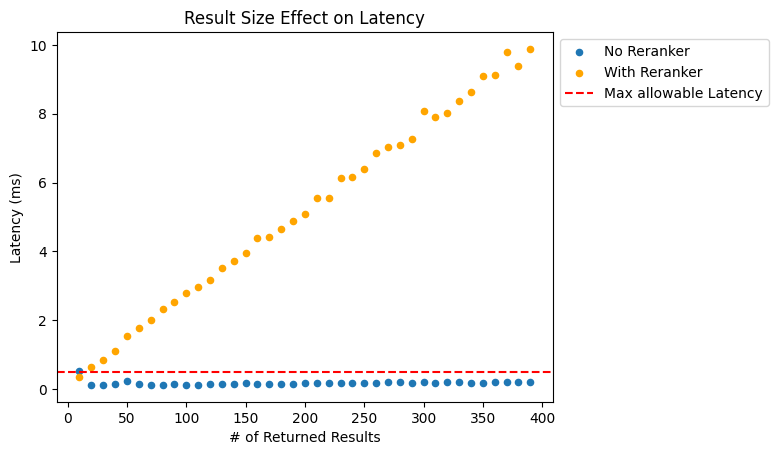

In [41]:
import time
import pandas as pd

def time_search(client: WeaviateWCS,
                collection_name: str,
                limit: int,
                rerank: bool
                ) -> float:
    '''
    Executes search given a limit value.
    Returns total time in seconds
    '''
    query = 'What is the best long term strategy for fat loss'
    start = time.perf_counter()
    response = client.hybrid_search(query, collection_name, limit=limit, return_properties=['content', 'title'])
    if rerank:
        reranked = reranker.rerank(response, query)
    end = time.perf_counter() - start
    return round(end, 3)

limit_values = list(range(10, 400, 10))

unranked_times = []
for n in tqdm(limit_values, 'Search: No Reranker'):
    unranked_times.append((time_search(client, collection_name, limit=n, rerank=False), n))


ranked_times = []
for n in tqdm(limit_values, 'Search: With Reranker'):
    ranked_times.append((time_search(client, collection_name, limit=n, rerank=True), n))



unranked = pd.DataFrame(unranked_times, columns=['time', 'n'])
ranked = pd.DataFrame(ranked_times, columns=['time', 'n'])

ax = unranked.plot.scatter(x='n', y='time', label='No Reranker', title='Result Size Effect on Latency')
ax2 = ranked.plot.scatter(x='n', y='time', ax=ax, color='orange', ylabel='Latency (ms)', label='With Reranker', xlabel='# of Returned Results')
hline = ax2.axhline(y = 0.5, color = 'r', linestyle = 'dashed', label = "Max allowable Latency")
legend = ax2.legend(bbox_to_anchor = (1.0, 1))

# Assignment 2.2 - New Retrieval Benchmark
***
**Reevaluate your retrieval results, this time using hybrid search and a Reranker** 

#### Instructions:
- Fill in the areas of the code wherever you see a `None` statement.  Use the `execute_evaluation` function to run your retrieval benchmark.
- `execute_evaluation` is the same function from Notebook 3, albeit with some modifications to incorporate hybrid search and Reranker functionality.
- Adjust the different hyperparameters to get the highest scoring retrieval score possible.

In [42]:
from src.database.database_utils import get_weaviate_client
from src.evaluation.retrieval_evaluation import execute_evaluation
from src.preprocessor.preprocessing import FileIO

from itertools import product

all_results = []

EMBEDDING_MODELS = [
    'sentence-transformers/all-MiniLM-L6-v2', # Baseline for the course
    'BAAI/bge-base-en-v1.5', # Higher ranked model on the MTEB
]
RERANKER_MODELS = [
    'cross-encoder/ms-marco-MiniLM-L-6-v2', # Baseline for the course
    'BAAI/bge-reranker-base', # Higher ranked model on the MTEB
]
CHUNK_SIZES = [128, 256, 512]
LIMITS = [50, 100, 250]
ALPHAS = [0.25, 0.5, 0.75]

corpus_path = '../data/huberman_labs.json'
corpus = FileIO.load_json(corpus_path)

client = get_weaviate_client()
all_collections = client.show_all_collections()

for (embedding_model_name, reranker_model_name, chunk_size, limit, alpha) in product(EMBEDDING_MODELS, RERANKER_MODELS, CHUNK_SIZES, LIMITS, ALPHAS):
    base_model_name = embedding_model_name.split("/")[1].lower().replace("-", "_").replace(".", "")
    collection_name = f'Huberman_{base_model_name}_{chunk_size}'

    if collection_name not in all_collections:
        continue

    print(f'Running test on embedding model {embedding_model_name}, reranker model {reranker_model_name}, chunk size {chunk_size}, limit {limit}, alpha {alpha}...')

    client = get_weaviate_client(model_name_or_path=embedding_model_name)
    reranker = ReRanker(model_name=reranker_model_name)

    data_path = f'../data/golden_datasets/golden_{chunk_size}.json'
    golden_dataset = FileIO().load_json(data_path)

    retrieval_results = execute_evaluation(dataset=golden_dataset, collection_name=collection_name, retriever=client, reranker=reranker, chunk_size=chunk_size, retrieve_limit=limit, alpha=alpha)
    all_results.append(retrieval_results)

/Users/fmc/miniconda3/envs/uplimit/lib/python3.10/site-packages/pydantic/_internal/_config.py:284: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)
/Users/fmc/miniconda3/envs/uplimit/lib/python3.10/site-packages/litellm/proxy/_types.py:167: PydanticDeprecatedSince20: Pydantic V1 style `@root_validator` validators are deprecated. You should migrate to Pydantic V2 style `@model_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  @root_validator(pre=True)
/Users/fmc/miniconda3/envs/uplimit/lib/python3.10/site-packages/litellm/proxy/_types.py:254: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use 

Running test on model sentence-transformers/all-MiniLM-L6-v2, chunk size 128...

Queries:  13%|█▎        | 13/100 [01:00<06:45,  4.66s/it]


KeyboardInterrupt: 

### Retrieval Score improvement

At this point in the course you have several options at your disposal to improve your retrieval score to maximize the relevance of the context that you will feed the LLM for the Question Answering phase of the system.  I'll list your options here, from least to most complex:
- Use hybrid search
- Experiment with the `alpha` parameter to see which value works best for this dataset
- Use a ReRanker
- Push the boundary on your reranker by maxing out the `retrieve_limit` value.  Try to keep latency below 500 ms.  
- Swap out your embedding model for a more performant one
- Find a better reranker on the MTEB leaderboard
- Fine-tune your embedding model
- Fine-tune your embedding model on a larger dataset than the 300 samples in the `training_data_300.json`.  You have the ability to create your own dataset through OpenAI and the `generate_finetune_datasets` notebook.
- Change the BM25 tokenizer

# Conclusion
***

Feel free to submit your new benchmark retrieval scores to move up on the Class Leaderboard!  I hope this notebook provided you with a better understanding of how Hybrid Search and CrossEncoders work under the hood.  
You are now prepared to move on to integrating your (high quality) retrieval results into an LLM for answer synthesis.  We'll next take a look at how we can build context options for the LLM and engineer our prompt to stack the deck in our favor.   Onward!